# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

### Using TensorFlow
Note that cuFFT/cuDNN/cuBLAS registration errors are expected with `tf=2.17.0` and will not affect behavior, as noted in [this issue.](https://github.com/tensorflow/tensorflow/issues/62075)  
This notebook does not demonstrate inference with TensorRT, as [TF-TRT](https://docs.nvidia.com/deeplearning/tensorrt/release-notes/index.html#tensorrt-10) does not yet support `tf=2.17.0`. See the `pytorch` notebooks for TensorRT demos.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf
import os

from tensorflow import keras

print(tf.version.VERSION)

2024-10-03 17:40:20.324462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 17:40:20.331437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 17:40:20.339109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 17:40:20.341362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 17:40:20.347337: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [3]:
# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Load and preprocess dataset

In [4]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [5]:
train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

train_images.shape, test_images.shape

((1000, 784), (1000, 784))

### Define a model

In [6]:
# Define a simple sequential model
def create_model():
    model = tf.keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-03 17:40:21.624052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45743 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Save checkpoints during training

In [7]:
checkpoint_path = "training_1/checkpoint.model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_sparse_categorical_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10


I0000 00:00:1727977222.161202 1835280 service.cc:146] XLA service 0x7ec778008e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727977222.161216 1835280 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-10-03 17:40:22.168848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 17:40:22.206298: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/32 ━━━━━━━━━━━━━━━━━━━━ 24s 778ms/step - loss: 2.3278 - sparse_categorical_accuracy: 0.1250

I0000 00:00:1727977222.715572 1835280 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5867 - sparse_categorical_accuracy: 0.5096  

2024-10-03 17:40:23.780912: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.78700, saving model to training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.5733 - sparse_categorical_accuracy: 0.5144 - val_loss: 0.7061 - val_sparse_categorical_accuracy: 0.7870
Epoch 2/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5514 - sparse_categorical_accuracy: 0.8438
Epoch 2: val_sparse_categorical_accuracy improved from 0.78700 to 0.83700, saving model to training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4276 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.5268 - val_sparse_categorical_accuracy: 0.8370
Epoch 3/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.9688
Epoch 3: val_sparse_categorical_accuracy improved from 0.83700 to 0.85600, saving model to training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2721 - sparse_categorical_accuracy: 0.9236 - val_loss: 0.4716 -

In [8]:
os.listdir(checkpoint_dir)

['checkpoint.model.keras']

In [9]:
# Export model in saved_model format
model.export("mnist_model")

INFO:tensorflow:Assets written to: mnist_model/assets


INFO:tensorflow:Assets written to: mnist_model/assets


Saved artifact at 'mnist_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139403584120848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139403240100240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139403240100048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139403240099856: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 - 0s - 10ms/step - loss: 2.4196 - sparse_categorical_accuracy: 0.0590
Untrained model, accuracy:  5.90%


In [11]:
# Load the weights from the checkpoint
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - 713us/step - loss: 0.4145 - sparse_categorical_accuracy: 0.8780
Restored model, accuracy: 87.80%


/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Checkpoint callback options

In [12]:
!rm -rf training_2
!mkdir training_2

In [13]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Calculate the number of batches per epoch
import math
n_batches = len(train_images) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)


Epoch 5: saving model to training_2/cp-0005.weights.h5

Epoch 10: saving model to training_2/cp-0010.weights.h5

Epoch 15: saving model to training_2/cp-0015.weights.h5

Epoch 20: saving model to training_2/cp-0020.weights.h5

Epoch 25: saving model to training_2/cp-0025.weights.h5

Epoch 30: saving model to training_2/cp-0030.weights.h5

Epoch 35: saving model to training_2/cp-0035.weights.h5

Epoch 40: saving model to training_2/cp-0040.weights.h5

Epoch 45: saving model to training_2/cp-0045.weights.h5

Epoch 50: saving model to training_2/cp-0050.weights.h5


In [14]:
os.listdir(checkpoint_dir)

['cp-0000.weights.h5',
 'cp-0015.weights.h5',
 'cp-0010.weights.h5',
 'cp-0035.weights.h5',
 'cp-0020.weights.h5',
 'cp-0040.weights.h5',
 'cp-0050.weights.h5',
 'cp-0005.weights.h5',
 'cp-0045.weights.h5',
 'cp-0025.weights.h5',
 'cp-0030.weights.h5']

In [15]:
latest = "training_2/cp-0030.weights.h5"

In [16]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model from the latest checkpoint
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - 9ms/step - loss: 0.4501 - sparse_categorical_accuracy: 0.8720
Restored model, accuracy: 87.20%


## PySpark

In [17]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkConf

In [ ]:
import os
conda_env = os.environ.get("CONDA_PREFIX")

conf = SparkConf()
if 'spark' not in globals():
    # If Spark is not already started with Jupyter, attach to Spark Standalone
    import socket
    hostname = socket.gethostname()
    conf.setMaster(f"spark://{hostname}:7077") # assuming Master is on default port 7077
conf.set("spark.task.maxFailures", "1")
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")
conf.set("spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled", "false")
conf.set("spark.sql.pyspark.jvmStacktrace.enabled", "true")
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
conf.set("spark.python.worker.reuse", "true")
# Create Spark Session
spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [19]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

(1000, 784)

In [20]:
%%time
df = spark.createDataFrame(test_pdf).repartition(8)

CPU times: user 134 ms, sys: 15.5 ms, total: 149 ms
Wall time: 1.36 s


### Save as Parquet (784 columns of float)

In [21]:
%%time
df.write.mode("overwrite").parquet("mnist_784")

24/10/03 17:40:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 2.49 ms, sys: 1.65 ms, total: 4.13 ms
Wall time: 1.66 s


### Save as Parquet (1 column of 784 float)

In [22]:
%%time
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 6.71 ms, sys: 4.92 ms, total: 11.6 ms
Wall time: 11.4 ms


(1000, 1)

In [23]:
%%time
df = spark.createDataFrame(pdf)

CPU times: user 46.6 ms, sys: 4.71 ms, total: 51.3 ms
Wall time: 91.7 ms


In [24]:
%%time
df.write.mode("overwrite").parquet("mnist_1")

CPU times: user 807 μs, sys: 724 μs, total: 1.53 ms
Wall time: 211 ms


### Check arrow memory configuration

In [25]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty" 

## Inference using Spark DL API

### 1 column of 784 float

In [26]:
import numpy as np
import os
import pandas as pd

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [27]:
# get absolute path to model
model_dir = "{}/training_1/checkpoint.model.keras".format(os.getcwd())

In [28]:
def predict_batch_fn():
    import tensorflow as tf

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    model = tf.keras.models.load_model(model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [29]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=1024,
                          input_tensor_shapes=[[784]])

In [30]:
df = spark.read.parquet("mnist_1")
len(df.columns)

1

In [31]:
df.show(5)

+--------------------+
|                data|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [32]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 18.5 ms, sys: 13.3 ms, total: 31.8 ms
Wall time: 5.03 s


In [33]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 37.3 ms, sys: 12.4 ms, total: 49.8 ms
Wall time: 259 ms


In [34]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 22.9 ms, sys: 5.96 ms, total: 28.8 ms
Wall time: 237 ms


#### Check predictions

In [35]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.88436, -3.1058547, 0.10873719, 12.67319, -..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.273286, -8.362554, 1.8936121, -3.8881433, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.3856308, 0.6785604, 1.3146863, 0.9275978, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.7754688, -7.3659225, 11.768427, 1.3434286,..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.9426627, 4.0774136, -0.4529277, -0.9312789..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.226616, -3.1389174, 2.6100307, 3.695045, -..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.3006196, 5.1169925, 0.5850615, -0.76248693..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.3985956, -1.4814724, -4.884057, -0.2391600..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.82160115, -2.8640625, -1.6951559, -4.489290..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.2338604, -2.151981, -4.171742, 1.6106845, ..."


In [36]:
sample = preds.iloc[0]
sample.preds

array([ -5.88436   ,  -3.1058547 ,   0.10873719,  12.67319   ,
        -5.143787  ,   4.0859914 , -10.203137  ,  -1.4333997 ,
        -3.3865087 ,  -3.8473575 ], dtype=float32)

In [37]:
import matplotlib.pyplot as plt
import numpy as np

In [38]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

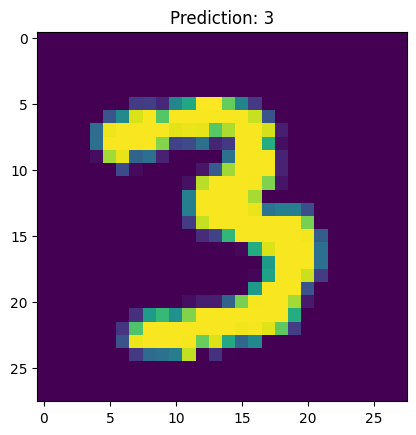

In [39]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### 784 columns of float

In [40]:
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [41]:
def predict_batch_fn():
    import tensorflow as tf
    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
            
    model = tf.keras.models.load_model(model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [42]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=1024,
                          input_tensor_shapes=[[784]])

In [43]:
df = spark.read.parquet("mnist_784")
len(df.columns)

784

In [44]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

CPU times: user 45.6 ms, sys: 26 ms, total: 71.6 ms
Wall time: 5.51 s


In [45]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 46.5 ms, sys: 34 ms, total: 80.5 ms
Wall time: 884 ms


In [46]:
# should raise ValueError
# preds = df.withColumn("preds", mnist(*df.columns)).collect()

### Check prediction

In [47]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,preds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-5.88436, -3.1058552, 0.108737305, 12.67319, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.2732859, -8.362555, 1.893612, -3.888143, 0..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.3856308, 0.6785604, 1.3146865, 0.9275978, ..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-2.775469, -7.3659234, 11.768431, 1.3434289, ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-4.942663, 4.0774136, -0.45292768, -0.9312788..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-5.226616, -3.1389174, 2.6100307, 3.695045, -..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-4.3006196, 5.116993, 0.5850617, -0.7624871, ..."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-2.398596, -1.4814726, -4.8840575, -0.2391601..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.82160157, -2.8640628, -1.6951559, -4.489291..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.2338604, -2.151981, -4.1717424, 1.6106843,..."


In [48]:
import matplotlib.pyplot as plt
import numpy as np

In [49]:
sample = preds.iloc[0]
sample.preds

array([ -5.88436  ,  -3.1058552,   0.1087373,  12.67319  ,  -5.1437874,
         4.085992 , -10.203137 ,  -1.4333997,  -3.3865087,  -3.8473575],
      dtype=float32)

In [50]:
prediction = np.argmax(sample.preds)
img = sample.drop('preds').to_numpy(dtype=float)
img = np.array(img).reshape(28,28)

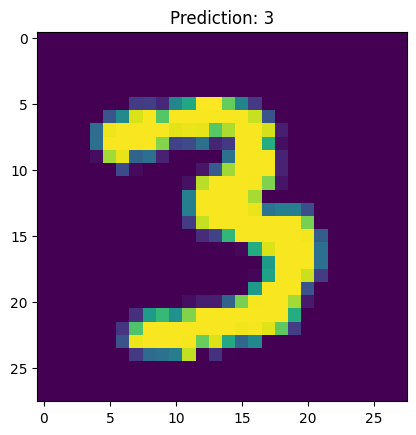

In [51]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [52]:
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [53]:
%%bash
# copy model to expected layout for Triton
rm -rf models
mkdir -p models/mnist_model/1
cp -r mnist_model models/mnist_model/1/model.savedmodel

# add config.pbtxt
cp models_config/mnist_model/config.pbtxt models/mnist_model/config.pbtxt

#### Start Triton Server on each executor

In [54]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:24.08-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={triton_models_dir: {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

[True]

In [55]:
df = spark.read.parquet("mnist_1")
df.schema

StructType([StructField('data', ArrayType(DoubleType(), True), True)])

#### Run inference

In [56]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient

    np_types = {
      "BOOL": np.dtype(np.bool_),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)

    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))

        response = client.infer(model_name, inputs=request)

        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)

    return predict

In [57]:
from functools import partial

predict = predict_batch_udf(partial(triton_fn, "localhost:8001", "mnist_model"),
                            return_type=ArrayType(FloatType()),
                            input_tensor_shapes=[[784]],
                            batch_size=8192)

In [58]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 20.1 ms, sys: 3.41 ms, total: 23.5 ms
Wall time: 625 ms


In [59]:
%%time
preds = df.withColumn("preds", predict("data")).collect()

CPU times: user 30.3 ms, sys: 8.81 ms, total: 39.2 ms
Wall time: 154 ms


In [60]:
%%time
preds = df.withColumn("preds", predict(col("data"))).limit(10).toPandas()
preds

CPU times: user 2.67 ms, sys: 4.2 ms, total: 6.87 ms
Wall time: 131 ms


,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.7614846, -3.52228, -1.1202906, 13.053683, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.1390061, -8.71185, 0.82955813, -4.034869, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.046528, 0.3521706, 0.6788677, 0.72303534, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.401024, -7.6780066, 11.145876, 1.2857256, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.0012593, 3.806796, -0.8154834, -0.9550028,..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.0425925, -3.4815094, 1.641246, 3.608149, -..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.288771, 5.0072904, 0.27649477, -0.797148, ..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.2032878, -1.6879876, -5.874276, -0.5945335..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.1337761, -3.1751056, -2.5246286, -5.028277,..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.92484117, -2.4703276, -5.023897, 1.46669, ..."


In [61]:
import matplotlib.pyplot as plt
import numpy as np

In [62]:
sample = preds.iloc[0]
sample.preds

prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

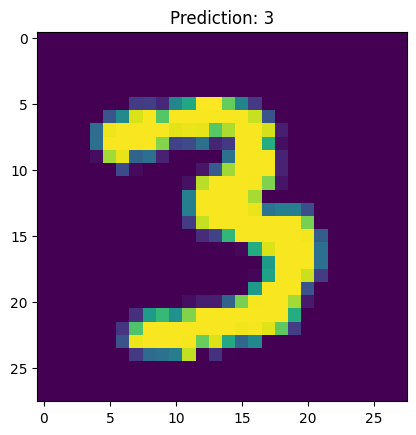

In [63]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

#### Stop Triton Server on each executor

In [64]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

[True]

In [65]:
spark.stop()